In [3]:
import sys
sys.path.append("../")
from src.functions.WL_partition import partition_graph
import networkx as nx

# Example of partitioning of the nodes using k-WL

For the moment, it only works until k=2. k>2 requires more involved initial node color definitions.

In [4]:
G = nx.Graph()
G_edge_list = [(0, 1), (1, 2), (2, 0),(2,3),(3,4),(4,5),(5,3),(0,5),(4,6),(6,7)]
G.add_edges_from(G_edge_list)

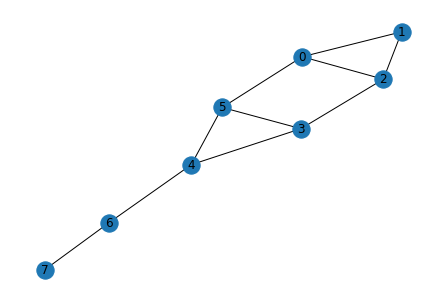

In [5]:
nx.draw(G,with_labels=True)

In [6]:
print("1-WL")
partition_graph(G, k=1)

1-WL


[[[0, 1, 2, 3, 4, 5, 6, 7]],
 [[7], [1, 6], [0, 2, 3, 4, 5]],
 [[6], [7], [0, 2, 4], [1], [3, 5]],
 [[0, 2], [4], [6], [3, 5], [1], [7]]]

In [7]:
print("2-WL")
partition_graph(G, k=2)

2-WL


[[[1, 6], [7], [0, 2, 3, 4, 5]],
 [[6], [0, 2, 4], [3, 5], [1], [7]],
 [[1], [6], [4], [3, 5], [7], [0, 2]]]

In [14]:
G = nx.Graph()
G_edge_list = [(0, 1), (1, 2), (0, 3),(3, 4),(1,4),(2,5),(4,5),(3,6),(4,7),(5,8), (6, 7), (7, 8), (8, 9)]
G.add_edges_from(G_edge_list)

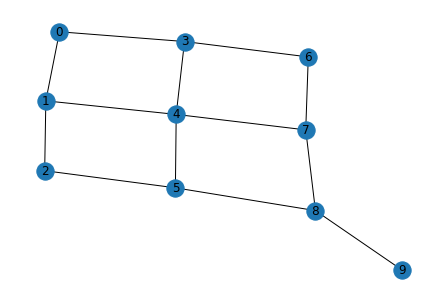

In [15]:
nx.draw(G,with_labels=True)

In [19]:
print("2-WL")
partition_graph(G, k=2)

2-WL


[[[1, 3, 5, 7, 8], [9], [4], [0, 2, 6]],
 [[9], [1, 3], [5, 7], [0, 2, 6], [4], [8]],
 [[2, 6], [9], [0], [8], [1, 3], [5, 7], [4]]]

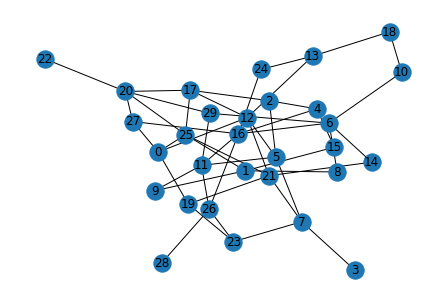

In [50]:
G = nx.erdos_renyi_graph(30, 0.1, seed=None, directed=False)
nx.draw(G,with_labels=True)

In [51]:
print("2-WL")
partition_graph(G, k=2)

2-WL


[[[16],
  [8, 9, 10, 14, 15, 18, 24],
  [0, 1, 5, 7, 17, 26],
  [6, 11, 12, 20, 21, 25],
  [3, 22, 28],
  [2, 4, 13, 19, 23, 27, 29]],
 [[26],
  [16],
  [19],
  [22],
  [4],
  [27],
  [0],
  [6],
  [1],
  [29],
  [15],
  [25],
  [20],
  [11],
  [2, 23],
  [12],
  [3, 28],
  [18],
  [7],
  [10],
  [17],
  [13],
  [24],
  [21],
  [5],
  [14],
  [8, 9]],
 [[2],
  [7],
  [4],
  [29],
  [0],
  [20],
  [18],
  [15],
  [13],
  [8],
  [11],
  [12],
  [22],
  [9],
  [1],
  [25],
  [17],
  [26],
  [16],
  [27],
  [6],
  [5],
  [28],
  [10],
  [23],
  [3],
  [24],
  [19],
  [14],
  [21]]]

# Development and Test stuff

In [1]:
import copy
import pprint
import itertools
import hashlib
import networkx as nx

from collections import Counter

In [14]:
def base_WL(G_, k, verbose, n_set, initial_colors_func, find_neighbors_func):    
    if verbose:
        print('-----------------------------------')
        print('Starting the execution for the graph')
    G, n = n_set(G_)
    colors = initial_colors_func(n)

    old_colors = copy.deepcopy(colors)

    colors_list = [copy.deepcopy(colors)]
    
    if verbose:
        print(f'Initial Color hashes: \n {colors} \n')

    for i in range(len(n)):

        for node in n:
            neigh_colors = [old_colors[i][0] for i in find_neighbors_func(G, n, node)]
            neigh_colors.sort()
            neigh_colors = "-".join(neigh_colors)
            
            colors[node].extend([neigh_colors])
            #colors[node].sort()

        # Update with the hash
        if verbose:
            print(f'Colors before hashes at iteration {i}: {colors} \n')
            print(f"Neighbors : ")
            for node in n:
                print(f"{node} : {find_neighbors_func(G, n, node)}")
        colors = {i: [hashlib.sha224("".join(colors[i]).encode('utf-8')).hexdigest()] for i in colors.keys()}
                
        if verbose:
            print(f'Colors hashes at iteration {i}: \n {colors} \n')
            print(f'Histogram: \n {sorted(Counter([item for sublist in colors.values() for item in sublist]).items())} \n')
        
        if list(Counter([item for sublist in colors.values() for item in sublist]).values()) == list(Counter([item for sublist in old_colors.values() for item in sublist]).values()) and i != 0:
            if verbose:
                print(f'Converged at iteration {i}!')
            break
        
        old_colors = copy.deepcopy(colors)
        colors_list.append(copy.deepcopy(colors))

    canonical_form = sorted(Counter([item for sublist in colors.values() for item in sublist]).items())
    if verbose:
        print(f'Canonical Form Found: \n {canonical_form} \n')

    return canonical_form, colors_list


In [15]:
def WL(G, k=2, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        return G, list(G.nodes())
    
    def set_initial_colors(n):
        return {i: [hashlib.sha224("1".encode('utf-8')).hexdigest()] for i in n}
    
    def find_neighbors(G, n, node):
        return G.neighbors(node)
    
    return base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)


In [16]:
def kWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        V_k = [comb for comb in itertools.combinations(V, k)]
        return G, V_k

    def set_initial_colors(n):
        pairs = list(itertools.combinations(np.arange(k),2))
        hash_dict = {}
        for i in n:
            str_ = []
            for p in pairs:
                node1 = i[p[0]]
                node2 = i[p[1]]
                if G.has_edge(node1,node2):
                    str_.append('E')
                else:
                    str_.append('0')
            hash_dict[i] = [hashlib.sha224(str(str_).encode('utf-8')).hexdigest()]

        return hash_dict

    def find_neighbors(G, V_k, node):
        print([n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1])
        return [n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1]

    return base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)


In [5]:
def fkWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        V_k = [comb for comb in itertools.product(V, repeat=k)]
        return G, V_k

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    def find_neighbors(G, V_k, node):
        V = list(G.nodes())
        vals = []
        for i in range(k):
            w = []
            nodes_to_add = [u for u in V if u != V_k[V_k.index(node)][i]]
            for u in nodes_to_add:
                aux = list(V_k[V_k.index(node)])
                aux[i] = u
                w.append(tuple(aux))
            vals.extend(w)
        return vals

    return base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)


In [17]:
def compare_graphs(G1, G2, method='WL', k=2, verbose=False):
    methods = {
        'WL': WL,
        'kWL': kWL,
        'fkWL': fkWL
    }

    # If two graphs have different numbers of nodes they cannot be isomorphic
    if len(G1.nodes()) != len(G2.nodes()):
        if verbose:
            print('Non-Isomorphic by different number of nodes!')
        return False
    
    c1 = methods[method](G1, k, verbose)
    c2 = methods[method](G2, k, verbose)

    return c1 == c2

In [18]:
G = nx.Graph()
G_edge_list = [(0, 1), (1, 2), (2, 0),(2,3),(3,4),(4,5),(5,3),(0,5),(4,6),(6,7)]
G.add_edges_from(G_edge_list)

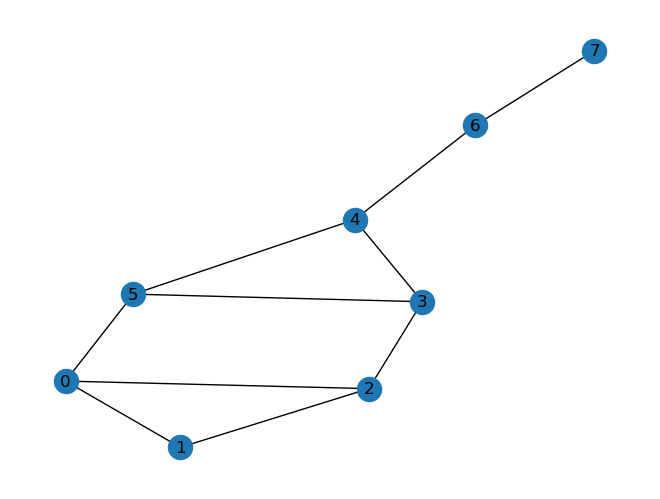

In [19]:
nx.draw(G,with_labels=True)

In [45]:
cform, c_list = WL(G,k=1,verbose=True)

-----------------------------------
Starting the execution for the graph
Initial Color hashes: 
 {0: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 1: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 2: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 3: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 4: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 5: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 6: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 7: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178']} 

Colors before hashes at iteration 0: {0: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178', 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178-e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178-e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 1: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178', 'e25388fde8290dc286a6164fa2d97e551b5349

In [21]:
cform, c_list = kWL(G,k=2,verbose=True)
N = len(G)

-----------------------------------
Starting the execution for the graph
Initial Color hashes: 
 {(0, 1): ['f7571c7414ad7edfa10c8232129e72d061add7ac2f83eca1528474c4'], (0, 2): ['f7571c7414ad7edfa10c8232129e72d061add7ac2f83eca1528474c4'], (0, 3): ['304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a'], (0, 4): ['304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a'], (0, 5): ['f7571c7414ad7edfa10c8232129e72d061add7ac2f83eca1528474c4'], (0, 6): ['304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a'], (0, 7): ['304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a'], (1, 2): ['f7571c7414ad7edfa10c8232129e72d061add7ac2f83eca1528474c4'], (1, 3): ['304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a'], (1, 4): ['304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a'], (1, 5): ['304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a'], (1, 6): ['304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a'], (1, 7): ['304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae293

In [26]:
processed

[{(0, 1): 'f7571c7414ad7edfa10c8232129e72d061add7ac2f83eca1528474c4',
  (0, 2): 'f7571c7414ad7edfa10c8232129e72d061add7ac2f83eca1528474c4',
  (0, 3): '304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a',
  (0, 4): '304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a',
  (0, 5): 'f7571c7414ad7edfa10c8232129e72d061add7ac2f83eca1528474c4',
  (0, 6): '304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a',
  (0, 7): '304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a',
  (1, 2): 'f7571c7414ad7edfa10c8232129e72d061add7ac2f83eca1528474c4',
  (1, 3): '304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a',
  (1, 4): '304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a',
  (1, 5): '304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a',
  (1, 6): '304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a',
  (1, 7): '304f784d5292b6dc7c90e491eda8e68bb5b093f7b70e774ae2934c3a',
  (2, 3): 'f7571c7414ad7edfa10c8232129e72d061add7ac2f83eca1528474c4',
  (2, 4): '304f784d5

In [31]:
meta_nodes.sort()

In [50]:
processed

[{0: 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178',
  1: 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178',
  2: 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178',
  3: 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178',
  4: 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178',
  5: 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178',
  6: 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178',
  7: 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'},
 {0: 'f9adf070160527d2634e977417c26bc617aa7f10087d0342cc493a53',
  1: '9029e47b96599a8a0edf9b6b50f9c2415776eace207a0796ec7ec35f',
  2: 'f9adf070160527d2634e977417c26bc617aa7f10087d0342cc493a53',
  3: 'f9adf070160527d2634e977417c26bc617aa7f10087d0342cc493a53',
  4: 'f9adf070160527d2634e977417c26bc617aa7f10087d0342cc493a53',
  5: 'f9adf070160527d2634e977417c26bc617aa7f10087d0342cc493a53',
  6: '9029e47b96599a8a0edf9b6b50f9c2415776eace207a0796ec7ec35f',
  7: '3380a481c174d91271

In [49]:
import numpy as np
processed = []
for c in c_list:
    processed.append({})
    for k,v in c.items():
        processed[-1][k] = v[0]

meta_processed = []
for proc in processed:
    cols = {}
    for n in range(N):
        meta_nodes = [v for k,v in proc.items() if n in k]
        meta_nodes.sort()
        col_ = hashlib.sha224("".join(meta_nodes).encode('utf-8')).hexdigest()
        cols[n] = col_
    meta_processed.append(cols)

#meta_processed = processed

partition = []
for s in meta_processed:
    s_u = np.unique(list(s.values()))
    partition_ = []
    for s_u_ in s_u:
        partition_.append([k for k,v in s.items() if v == s_u_])
    partition.append(partition_)

prev_p = set()
filtered_partition = []
for p_ in partition:
    new_set = set([tuple(i) for i in p_])
    if new_set == prev_p:
        break
    filtered_partition.append(p_)
    prev_p = new_set

TypeError: argument of type 'int' is not iterable

In [44]:
filtered_partition

[[[1, 6], [7], [0, 2, 3, 4, 5]],
 [[6], [0, 2, 4], [3, 5], [1], [7]],
 [[1], [6], [4], [3, 5], [7], [0, 2]]]

In [33]:
partition

[[[1, 6], [7], [0, 2, 3, 4, 5]],
 [[6], [0, 2, 4], [3, 5], [1], [7]],
 [[1], [6], [4], [3, 5], [7], [0, 2]],
 [[3, 5], [1], [4], [6], [7], [0, 2]]]

In [ ]:
def partition_graph(G,k):
    if k==1:
        cform, c_list = WL(G,k=1,verbose=True)
    elif k==2:
        cform, c_list= kWL(G,k=2,verbose=True)
    else:
        raise NotImplementedError
    
    N = len(G)

    processed = []
    for c in c_list:
        processed.append({})
        for k,v in c.items():
            processed[-1][k] = v[0]

    if k==1:
        meta_processed = processed
    else: # key is a tuple (edges) - need another round of hashing
        meta_processed = []
        for proc in processed:
            cols = {}
            for n in range(N):
                meta_nodes = [v for k,v in proc.items() if n in k]
                meta_nodes.sort()
                col_ = hashlib.sha224("".join(meta_nodes).encode('utf-8')).hexdigest()
                cols[n] = col_
            meta_processed.append(cols)

    #Transforming into index partition
    partition = []
    for s in meta_processed:
        s_u = np.unique(list(s.values()))
        partition_ = []
        for s_u_ in s_u:
            partition_.append([k for k,v in s.items() if v == s_u_])
        partition.append(partition_)

    #Dropping the partition that repeat
    prev_p = set()
    filtered_partition = []
    for p_ in partition:
        new_set = set([tuple(i) for i in p_])
        if new_set == prev_p:
            break
        filtered_partition.append(p_)
        prev_p = new_set

    return filtered_partition

In [213]:
c_list

[{0: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'],
  1: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'],
  2: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'],
  3: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'],
  4: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'],
  5: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'],
  6: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'],
  7: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178']},
 {0: ['27cf717db95090c73053b0eb6f28bac67485a28f8b8e6672321d0ed4'],
  1: ['8e8ddf946194dfa83fb5233a59696ecead245fa7b82aeb45b8beb992'],
  2: ['27cf717db95090c73053b0eb6f28bac67485a28f8b8e6672321d0ed4'],
  3: ['27cf717db95090c73053b0eb6f28bac67485a28f8b8e6672321d0ed4'],
  4: ['27cf717db95090c73053b0eb6f28bac67485a28f8b8e6672321d0ed4'],
  5: ['27cf717db95090c73053b0eb6f28bac67485a28f8b8e6672321d0ed4'],
  6: ['8e8ddf946194dfa83fb5233a59696ecead245fa7b82aeb45b8beb9

In [31]:
G = nx.Graph()
G_edge_list = [(1, 2), (2, 3), (3, 1),(3,4)]
G.add_edges_from(G_edge_list)

compare_graphs(G, G, k=1, verbose=True, method='WL')

-----------------------------------
Starting the execution for the graph
Initial Color hashes: 
 {0: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 1: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 2: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 3: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178']} 

Colors before hashes at iteration 0: {0: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178', 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 1: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178', 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 2: ['e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178', 'e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178e25388fde8290dc286a6164fa2d97e551b53498dcbf7bc378eb1f178'], 3: 

True